In [1]:
!pip install efficientnet

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 
import random

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
# from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D, AveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import efficientnet.keras as enet

2024-05-21 08:11:49.492556: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-21 08:11:50.262095: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-05-21 08:11:50.262184: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-05-21 08:11:50.262193: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

# Data Augmentation

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   rotation_range=40,       # Randomly rotate images in the range (degrees, 0 to 180)
                                    width_shift_range=0.2,   # Randomly shift images horizontally (fraction of total width)
                                    height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
                                    shear_range=0.2,         # Randomly apply shearing transformations
                                    zoom_range=0.2,          # Randomly zoom inside images
                                    horizontal_flip=True,    # Randomly flip images horizontally
                                    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   rotation_range=40,       # Randomly rotate images in the range (degrees, 0 to 180)
                                    width_shift_range=0.2,   # Randomly shift images horizontally (fraction of total width)
                                    height_shift_range=0.2,  # Randomly shift images vertically (fraction of total height)
                                    shear_range=0.2,         # Randomly apply shearing transformations
                                    zoom_range=0.2,          # Randomly zoom inside images
                                    horizontal_flip=True,    # Randomly flip images horizontally
                                    fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale = 1./255) 

In [4]:
train_dataset  = train_datagen.flow_from_directory(directory = '../augmented_split/train/',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 1436 images belonging to 20 classes.


In [5]:
valid_dataset = valid_datagen.flow_from_directory(directory = '../augmented_split/val/',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 67 images belonging to 20 classes.


In [6]:
train_dir = "../augmented_split/train"
val_dir = "../augmented_split/val"
test_dir = "../augmented_split/test"

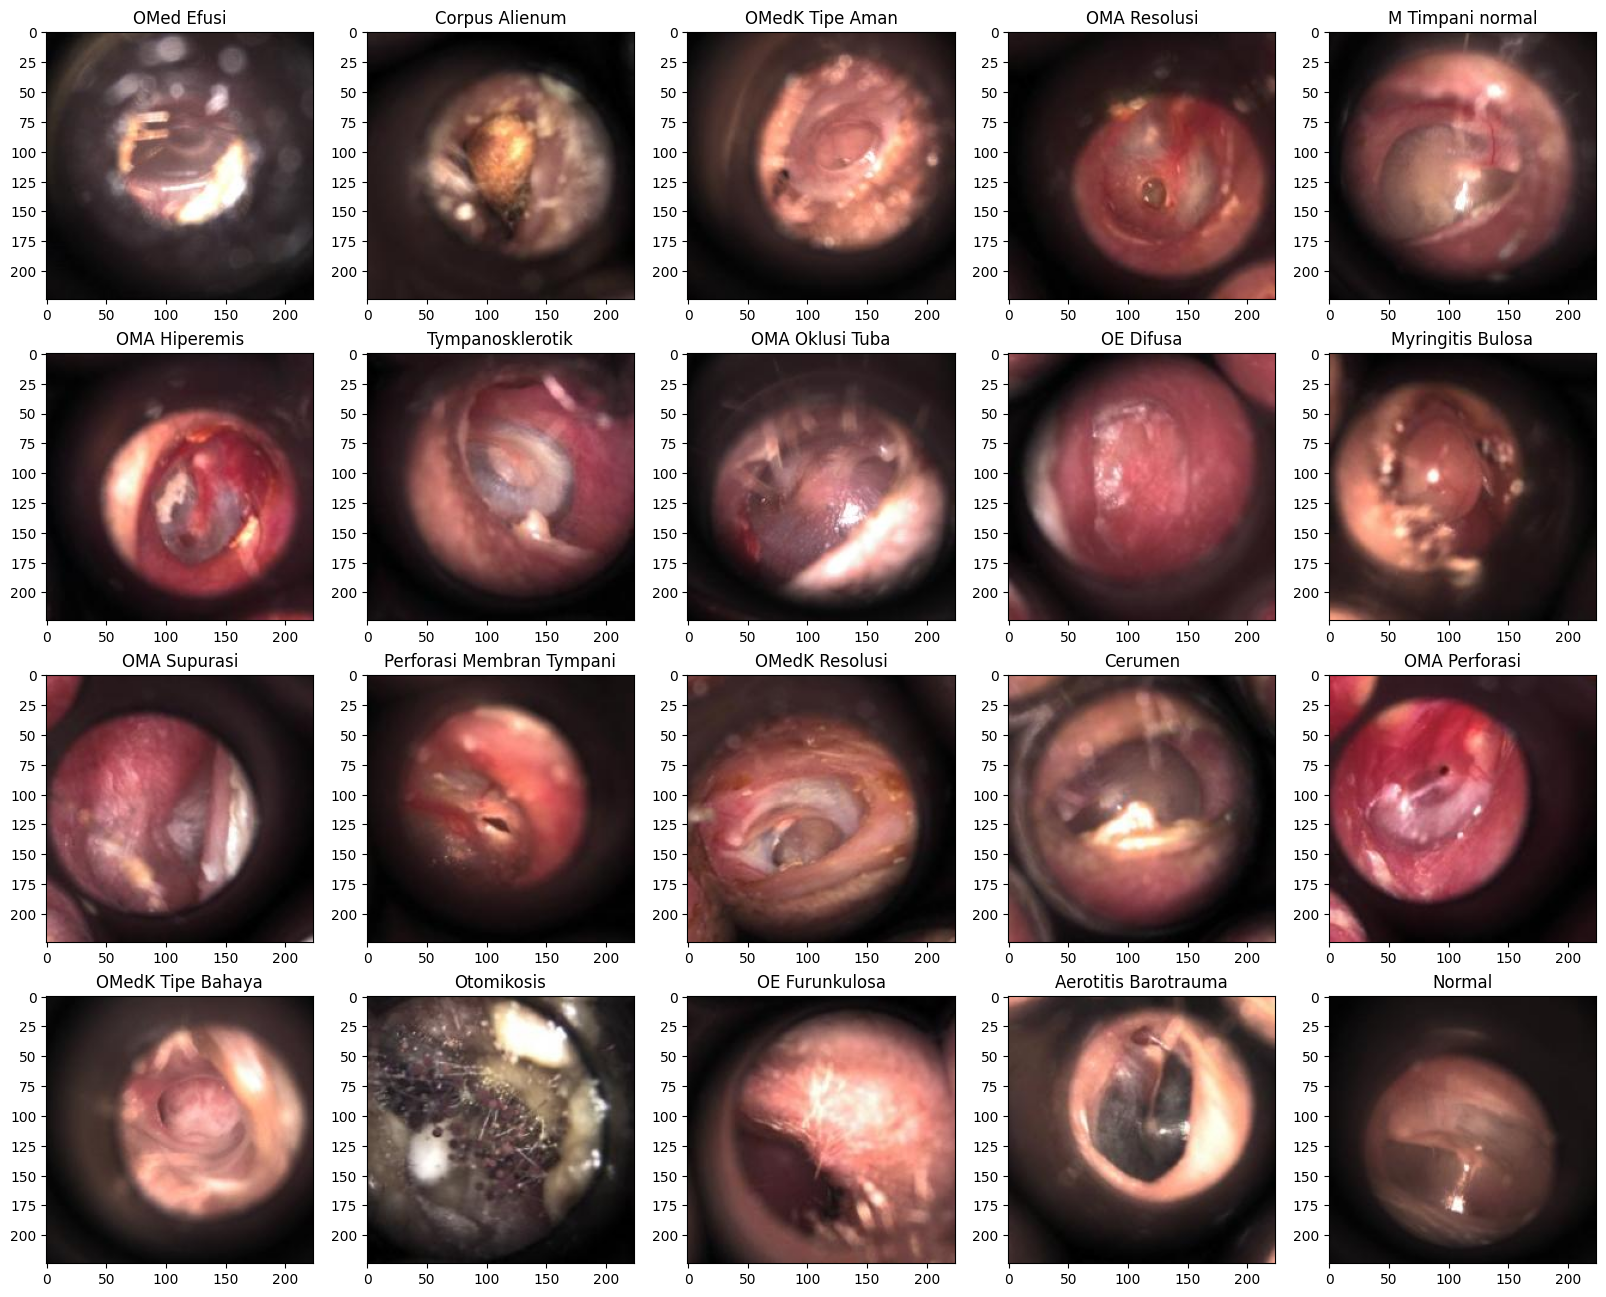

In [7]:
# dataset exploration
# load salah satu citra dari masing masing class yang ada, dan menjadikannya sebagai sebuah tensor
explor_data = []
labels = []
for label in os.listdir(test_dir): #loop masing masing class
  path = test_dir+'/'+label
  img_paths = os.listdir(path)
  random.shuffle(img_paths)
  img_path = path+'/'+img_paths[0]
  img = plt.imread(img_path) #load image
  explor_data.append(img) #masukan citra kedalam list
  labels.append(label) #masukan encoded label kedalam list

explor_data = np.array(explor_data)
explor_data.shape

plt.figure(figsize=(20,16))
for i in range(20):
  plt.subplot(4,5,i+1)
  plt.title(labels[i])
  plt.imshow( explor_data[i] )

In [8]:
base_model = enet.EfficientNetB2(input_shape=(224,224,3), 
                                 include_top=False,
                                 weights="imagenet")

2024-05-21 08:11:55.153023: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-21 08:11:55.196824: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2024-05-21 08:11:55.196849: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-05-21 08:11:55.197259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

In [9]:
for layer in base_model.layers:
    layer.trainable=False

In [10]:
model=Sequential()
model.add(base_model)
model.add(AveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(256,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(20,activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b2 (Functional  (None, 7, 7, 1408)       7768562   
 )                                                               
                                                                 
 average_pooling2d (AverageP  (None, 3, 3, 1408)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 3, 3, 1408)       5632      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 3, 3, 1408)        0         
                                                                 
 flatten (Flatten)           (None, 12672)             0         
                                                        

In [12]:
# Model Compile 

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy', tensorflow.keras.metrics.AUC(name = 'auc'), tensorflow.keras.metrics.Precision(), tensorflow.keras.metrics.Recall()],
              optimizer=tensorflow.keras.optimizers.Adam(lr=0.005))

In [13]:
filepath = './v3_b2.h5'

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_loss', 
                                mode='min', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [checkpoint]

In [14]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 60,
                         
                        callbacks = callback_list)

Epoch 1/60
23/23 [==============================] - ETA: 0s - loss: 3.3541 - accuracy: 0.0773 - auc: 0.5608 - precision: 0.0889 - recall: 0.0028
Epoch 1: val_loss improved from inf to 2.99308, saving model to ./v3_b2.h5
23/23 [==============================] - 60s 2s/step - loss: 3.3541 - accuracy: 0.0773 - auc: 0.5608 - precision: 0.0889 - recall: 0.0028 - val_loss: 2.9931 - val_accuracy: 0.1940 - val_auc: 0.6697 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
23/23 [==============================] - ETA: 0s - loss: 2.9966 - accuracy: 0.1219 - auc: 0.6454 - precision: 0.3250 - recall: 0.0091
Epoch 2: val_loss improved from 2.99308 to 2.42494, saving model to ./v3_b2.h5
23/23 [==============================] - 51s 2s/step - loss: 2.9966 - accuracy: 0.1219 - auc: 0.6454 - precision: 0.3250 - recall: 0.0091 - val_loss: 2.4249 - val_accuracy: 0.2537 - val_auc: 0.7914 - val_precision: 1.0000 - val_recall: 0.0149
Epoch 3/60
23/23 [==============================] - ETA: 0s - 

In [22]:
base_model.summary()

Model: "efficientnet-b2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                                )                                                   

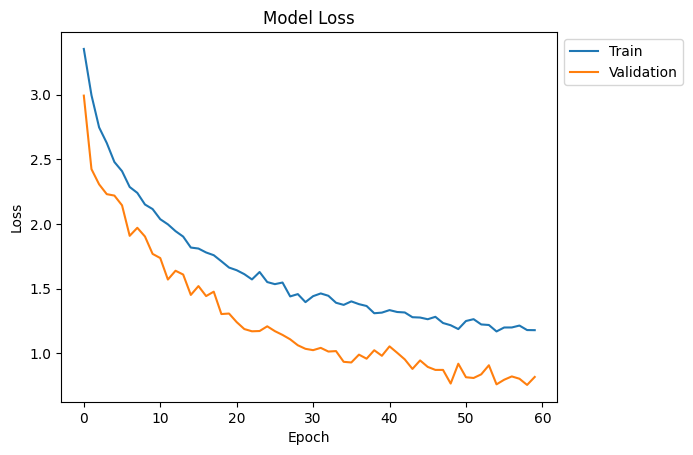

In [23]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

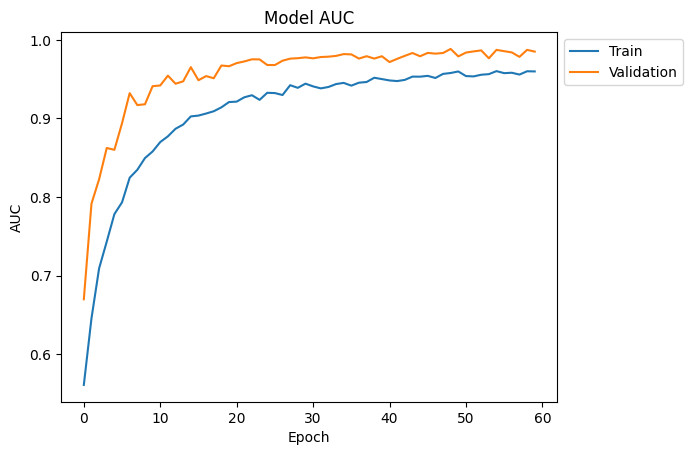

In [24]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

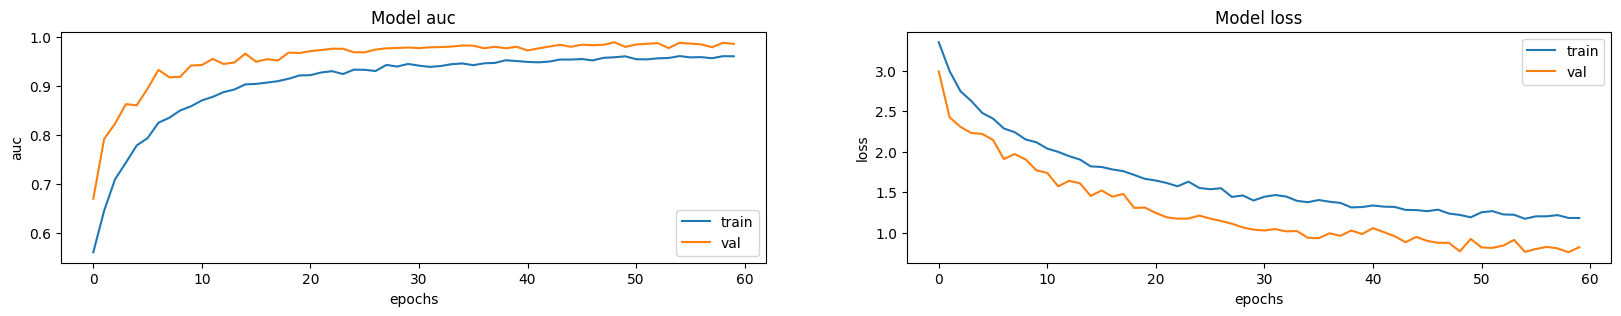

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(model_history.history[met])
    ax[i].plot(model_history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [26]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = '../augmented_split/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 64,
                                                 shuffle=False)

Found 401 images belonging to 20 classes.


In [27]:
model.evaluate(test_dataset)

7/7 [==============================] - 19s 3s/step - loss: 0.8304 - accuracy: 0.7157 - auc: 0.9801 - precision: 0.8453 - recall: 0.5860


[0.8303834795951843,
 0.7157106995582581,
 0.9801297187805176,
 0.8453237414360046,
 0.586034893989563]

In [21]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

# Get the true labels and predicted labels
y_true = test_dataset.classes
y_pred = model.predict(test_dataset)
y_pred_classes = tensorflow.argmax(y_pred, axis=1).numpy()


7/7 [==============================] - 17s 2s/step - loss: 0.8304 - accuracy: 0.7157 - auc: 0.9801 - precision: 0.8453 - recall: 0.5860


ValueError: too many values to unpack (expected 2)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Get the class labels
class_labels = list(test_dataset.class_indices.keys())

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)  # Rotate x-axis labels if they are too long
plt.show()


NameError: name 'y_true' is not defined